In [1]:
import jax
import jax.numpy as jnp
from jax import jit, grad, jacfwd, hessian
import numpy as np
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def rk4_step(f, x, h):
    # one step of runge-kutta integration
    k1 = h * f(x)
    k2 = h * f(x + k1/2)
    k3 = h * f(x + k2/2)
    k4 = h * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [22]:
l1 = 1.0
l2 = 1.0 
m1 = 1.0 
m2 = 1.0
def p1(q):
    th1, th2 = q
    return jnp.array([
        l1 * jnp.sin(th1),
        -l1 * jnp.cos(th1)
    ])
jac_p1 = jacfwd(p1)
def p2(q):
    th1, th2 = q
    return p1(q) + jnp.array([
        l2 * jnp.sin(th1+th2),
        -l2 * jnp.cos(th1+th2)
    ])
jac_p2 = jacfwd(p2)

In [128]:
q = np.array([0.7, 0.6])
qdot = np.array([7.8,6.07])
_M1 = np.diag([m1, m1])
_M2 = np.diag([m2, m2])

def K(q, qdot):
    v1 = jac_p1(q) @ qdot 
    v2 = jac_p2(q) @ qdot 
    return 0.5 * v1 @ _M1 @ v1 + 0.5 * v2 @ _M2 @ v2
    # return 0.5 * m1* v1 @ v1 + 0.5 * m2* v2 @ v2

def V(q):
    return m1 * 9.81 * p1(q)[1] + m2 * 9.81 * p2(q)[1]

def L(q, qdot):
    return K(q, qdot) - V(q)

def M_derived(q, qdot):
    return hessian(L, 1)(q, qdot)

def C_derived(q, qdot):
    return jacfwd(jacfwd(L,1),0)(q, qdot)

def G_derived(q, qdot):
    return jacfwd(L, 0)(q, qdot)

@jit
def f_derived(state):
    q, qdot = jnp.split(state, 2)
    qddot = jnp.linalg.pinv(M_derived(q, qdot)) \
            @ (G_derived(q, qdot) - C_derived(q,qdot) @ qdot )
    return jnp.concatenate([qdot, qddot])


In [129]:
def K_analytical(q,qdot):
    return 0.5*(m1+m2)*l1**2*qdot[0]**2 \
            + 0.5 * m2*l2**2*(qdot[0]+qdot[1])**2 \
            + m2*l1*l2*qdot[0]*(qdot[0] + qdot[1])*np.cos(q[1])

In [130]:
K_analytical(q, qdot)

246.31820883461847

In [131]:
K(q,qdot)

DeviceArray(246.31822, dtype=float32)

In [132]:
def M_analytical(q):
    th1, th2 = q
    c2 = np.cos(th2)
    return np.array([
        [(m1+m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*c2, m2*l2**2 + m2*l1*l2*c2],
        [m2*l2**2 + m2*l1*l2*c2, m2*l2**2]
    ])

def C_analytical(q, qdot):
    th1, th2 = q
    th1d, th2d = qdot
    s2 = np.sin(th2)
    return np.array([
        [0.0, -m2*l1*l2*(2*th1d+th2d)*s2],
        [0.0, -m2*l1*l2*th1d*s2]
    ])

def G_analytical(q, qdot):
    th1, th2 = q
    th1d, th2d = qdot
    s1 = np.sin(th1)
    s2 = np.sin(th2)
    s12 = np.sin(th1+th2)
    return np.array([
            -9.81 * (m1+m2)*l1*s1 + -9.81 * m2*l2*s12,
            -m2*l1*l2*(th1d + th2d)*th1d*s2 - 9.81 * m2*l2*s12
    ])

def f_analytical(state):
    q, qdot = np.split(state, 2)
    qddot = np.linalg.pinv(M_analytical(q)) \
            @ (G_analytical(q, qdot) - C_analytical(q, qdot) @ qdot )
    return np.concatenate([qdot, qddot])

In [133]:
print(grad(L, 0)(q, qdot))
G_analytical(q, qdot)

[-22.092066 -70.53893 ]


array([-22.09205682, -70.53891643])

In [134]:
print(jacfwd(jacfwd(L,1),0)(q, qdot))
C_analytical(q,qdot)

[[-1.2363261e-06 -1.2235803e+01]
 [ 4.7683716e-07 -4.4042115e+00]]


array([[  0.        , -12.2358024 ],
       [  0.        ,  -4.40421129]])

In [135]:
print(hessian(L, 1)(q, qdot))
M_analytical(q)

[[4.650672  1.8253357]
 [1.8253357 1.       ]]


array([[4.65067123, 1.82533561],
       [1.82533561, 1.        ]])

In [136]:
trajectory = {'analytical' : [], 'derived' : [], 'lagrangian' : []}
dt = 0.1
tf = 10
N = int(tf/dt)
x0 = np.array([0.6,1.2,0.,0.])
x0A = x0.copy()
x0D = x0.copy()
for t in range(N):
    trajectory['analytical'].append(x0A[:2])
    trajectory['derived'].append(x0D[:2])
    # trajectory['lagrangian'].append(lagrangian(*np.split(x0A,2)))
#     x0A = x0A + f_analytical(x0A)*dt
#     x0D = x0D + f_derived(x0D)*dt
    x0A = rk4_step(f_analytical, x0A, dt)
    x0D =  rk4_step(f_derived, x0D, dt)
    

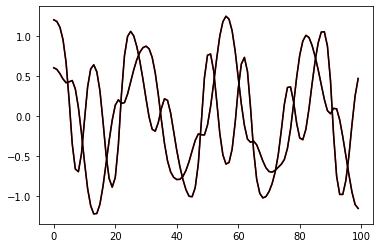

In [137]:
plt.plot(trajectory['analytical'], 'r')
plt.plot(trajectory['derived'], 'k')